In [66]:
from torch_geometric.datasets import Planetoid, MNISTSuperpixels
import torch_geometric.transforms as T
from torchvision.datasets import MNIST
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import numpy as np
import utils
from torch_geometric.data import Data, Batch, DataLoader
from IPython.display import display, clear_output
import multiprocessing
import time

In [67]:
print("Reading dataset")
dataset = MNIST("data/mnist", download=True)
# dataset = MNISTSuperpixels(root = '../data/mnist')

Reading dataset


(60000, 28, 28, 1)


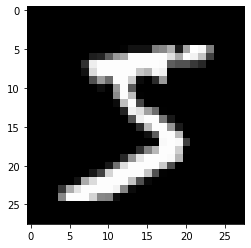

In [68]:
images = dataset.data.unsqueeze(-1).numpy().astype(np.float64)
print(images.shape)

first_image = images[0]
plt.imshow(first_image, cmap='gray')
plt.show()

In [69]:
labels = dataset.targets.numpy()

In [ ]:
print("Processing test images into graphs...")
ptime = time.time()

with multiprocessing.Pool() as p:
    graphs = p.map(utils.get_graph_from_image, images)
    
data = []
for g, l in zip(graphs, labels):
    x, edge_index, pos = g
    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    pos = torch.tensor(pos, dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, pos=pos, label=l)
    data.append(graph)
    
train_data = data[:50000]
test_data = data[50000:]
    
ptime = time.time() - ptime
print("Took {ptime}s".format(ptime=ptime))
print("Data length:", len(data))

In [70]:
torch.save(train_data, "data/MNISTSuperpixels_train_data.pt")
torch.save(test_data, "data/MNISTSuperpixels_test_data.pt")

Processing test images into graphs...
Took 119.72724413871765s
Data length: 60000


<h3>alternative way without multiprocessing</h3>

In [71]:
# print("Processing images into graphs...", end="")
# ptime = time.time()

# data = []
# i = 0
# for img in images[:1000]:
#     x, edge_index, pos = utils.get_graph_from_image(first_image)

#     x = torch.tensor(x, dtype=torch.float)
#     edge_index = torch.tensor(edge_index, dtype=torch.long).T
#     pos = torch.tensor(pos, dtype=torch.float)

#     graph = Data(x=x, edge_index=edge_index, pos=pos)
#     data.append(graph)

#     clear_output(wait=True)
#     display('Iteration ' + str(i))
#     i += 1
    
# ptime = time.time() - ptime
# print(" Took {ptime}s".format(ptime=ptime))

# torch.save(data, "data/MNISTSuperpixels.pt")

In [72]:
train_data = torch.load("data/MNISTSuperpixels_train_data.pt")
print(train_data[0])
test_data = torch.load("data/MNISTSuperpixels_test_data.pt")
print(test_data[0])

Data(edge_index=[2, 472], label=5, pos=[77, 2], x=[77, 3])
Data(edge_index=[2, 488], label=3, pos=[81, 2], x=[81, 3])


In [73]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)